#### Ejecutar en caso de tener el dataset subido a Google Colaboratory para entrenar el modelo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Librerias necesarias

In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation,Dropout, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report

#### Funciones útiles

In [8]:
def print_info(  test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print(msg)
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print(msg)
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print(msg)
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set') 
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width=length
            fig_height=length
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation=90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [9]:
def tr_plot(tr_data, start_epoch):
    
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [10]:
def display_eval_metrics(e_data):
    msg='Model Metrics after Training'
    print(msg)
    msg='{0:^24s}{1:^24s}'.format('Metric', 'Value')
    print(msg)
    for key,value in e_data.items():
        print (f'{key:^24s}{value:^24.5f}')
    acc=e_data['accuracy']* 100
    return acc

In [11]:
def scalar(img):
        return img/127.5 -1

#### Rutas a los diretorios con las imagenes. Cambiar la variable path por la ruta donde se encuentre el dataset

In [13]:
#Path to images
path = "/content/drive/MyDrive/path/to/my/images"
image_dir = Path(path)

#### Preprocesamiento de las imagenes con generators

In [14]:
labels = []    
filepaths = list(image_dir.glob('**/*.jpg'))
for f in filepaths:
	tsplit = os.path.split(os.path.split(f)[0])[1] # split filenames to get the label
	labels.append(tsplit)    
filepaths = pd.Series(filepaths, name = 'Filepath').astype(str)
labels = pd.Series(labels, name = 'Label')
image_df = pd.concat([filepaths, labels], axis = 1) # concatenate series into a data frame

#Train and test split ratio
train_split = 0.9
test_split = 0.05

# split dataframe into train, test and valid dataframes    
dummy_split = test_split/(1.0 - train_split)
train_df, no_train_df = train_test_split(image_df, train_size = train_split, shuffle = True, random_state = 123)
test_df, valid_df = train_test_split(no_train_df, train_size = dummy_split, shuffle = True, random_state = 123)

#Generator of images
generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = scalar)

#Train images generator
train_gen = generator.flow_from_dataframe(train_df, x_col = 'Filepath', y_col = 'Label', target_size = (224, 224),
								class_mode = 'categorical', batch_size = 80, shuffle = True, random_state = 123)
#Test images generator								
test_gen = generator.flow_from_dataframe(test_df, x_col = 'Filepath', y_col = 'Label', target_size = (224, 224), 
								class_mode = 'categorical', batch_size = 32, shuffle = False)
#Validation images generator
valid_gen = generator.flow_from_dataframe(valid_df, x_col = 'Filepath', y_col = 'Label', target_size = (224, 224),
								class_mode = 'categorical', batch_size = 32, shuffle = False)

Found 5463 validated image filenames belonging to 8 classes.
Found 303 validated image filenames belonging to 8 classes.
Found 304 validated image filenames belonging to 8 classes.


#### Modelo MobileNet usando transfer - learning. Se puede usar cualquier otro [modelo pre entrenado de Keras](https://keras.io/api/applications/)

In [15]:
#MobileNet
pretrained_model = tf.keras.applications.MobileNet(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'max',
)

#Freeze all layers 
pretrained_model.trainable = False 

#Inputs are the model inputs
inputs = pretrained_model.input

#We define our own top classifier with 0.4 rate dropout and eight neurons softmax function
x = pretrained_model.output
x = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001 )(x)
x = tf.keras.layers.Dense(1024, kernel_regularizer = tf.keras.regularizers.l2(l = 0.016), activity_regularizer = tf.keras.regularizers.l1(0.006),
        bias_regularizer = tf.keras.regularizers.l1(0.006), activation='relu', kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 123))(x)
x = tf.keras.layers.Dropout(rate = 0.3, seed = 123)(x) 
output = tf.keras.layers.Dense(8, activation = 'softmax', kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 123))(x)

model = tf.keras.Model(inputs=inputs, outputs=output)

#Compile model with lr = 0.001 and categorical loss entropy
model.compile(Adamax(lr = 0.001), loss = 'categorical_crossentropy', metrics = 'accuracy') 

17227776/17225924 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#### Imprimimos la arquitectura del modelo cargado con el clasificador propio para comprobar que está correcta

In [16]:
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

#### Training

In [ ]:
history = model.fit(x = train_gen,  epochs = 10, verbose = 1, callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 3,
            restore_best_weights = True
        )
    ],  validation_data = valid_gen,
                 shuffle = False,  initial_epoch = 0)

Epoch 1/10
13/69 [====>.........................] - ETA: 17:27 - loss: 19.6776 - accuracy: 0.3721

#### Plotear los resultados de entrenamiento

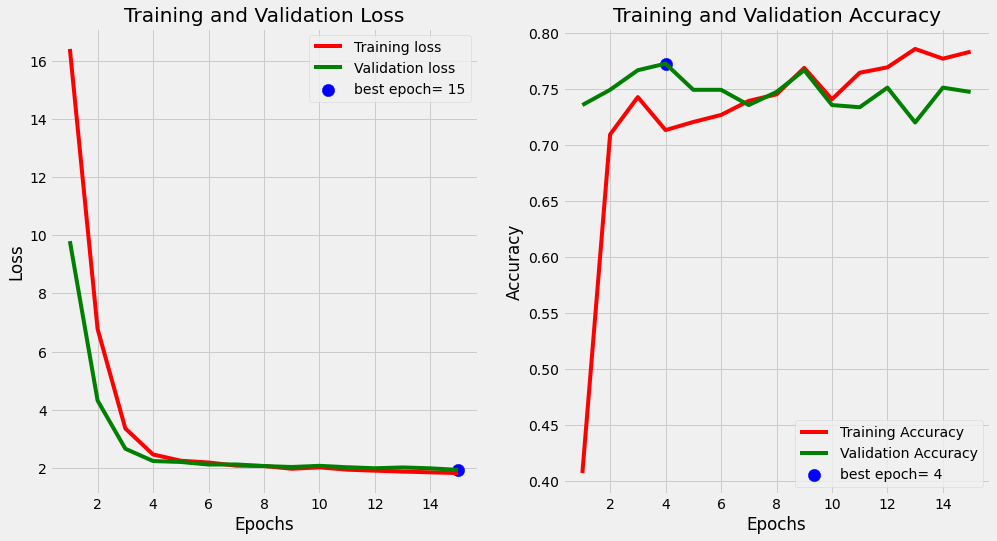

In [ ]:
tr_plot(history, 0)

#### Salvar el modelo 

In [ ]:
path_to_save = "path/to/save/my/model"
model.save(path_to_save)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#### Imprimir matriz de confusión y classification report

In [ ]:
preds=model.predict(test_gen,  verbose=1)
print_code=25 # maximum number of misclassifications to print out
save_dir = r'./'
subject = 'marvel characters'
print_info(  test_gen, preds, print_code, save_dir, subject )